## "Data Grabber" for quantative analysis of stocks
---

**Created By Paras Patange**


**Goal:** To create a grabber tool which will grab data from the web and create a CSV file which can be read to do analysis.

**Enter Discussion Partner IDs Below:**
You could add more IDs with the same markdown format above.

**Import Statements:**

In [39]:
import datetime
import yfinance as yf
import pandas as pd
import numpy as np
import sklearn
from scipy.stats import norm
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


Small Test If Data Can be Grabbed

In [22]:
# Define the stock tickers and time period
tickers = [ "AMZN", "TSLA", "GOOGL", "MSFT"]
#"AMZN", "TSLA" "GOOGL", "MSFT""AMZN", "TSLA", "GOOGL"
start_date = "2023-05-01"
end_date = "2023-12-04"

# Fetch historical stock prices
data = yf.download(tickers, start=start_date, end=end_date)

# Display the first few rows of the data
print(data.head())
print("LENGTH IS",len(data))


[**********************75%%**********            ]  3 of 4 completed

[*********************100%%**********************]  4 of 4 completed
             Adj Close                                           Close  \
                  AMZN       GOOGL        MSFT        TSLA        AMZN   
Date                                                                     
2023-05-01  102.050003  107.199997  303.633057  161.830002  102.050003   
2023-05-02  103.629997  105.320000  303.483978  160.309998  103.629997   
2023-05-03  103.650002  105.410004  302.480377  160.610001  103.650002   
2023-05-04  104.000000  104.690002  303.483978  161.199997  104.000000   
2023-05-05  105.660004  105.570000  308.690948  170.059998  105.660004   

                                                      High              ...  \
                 GOOGL        MSFT        TSLA        AMZN       GOOGL  ...   
Date                                                                    ...   
2023-05-01  107.199997  305.559998  161.830002  105.230003  107.989998  ...   
2023-05-02  105.320000

# For Data which is not on us Stock exchange, please run the following code
- Make the following change for stocks on the Indian Exchange (Ticker + ".NS")

In [23]:

# # Define the stock tickers and time period for Indian stocks
# tickers = ["RTNPOWER.NS", "IDFC.NS"]
# start_date = "2015-05-01"
# end_date = "2023-12-04"

# # Fetch historical stock prices for Indian stocks
# data = yf.download(tickers, start=start_date, end=end_date)

# # Display the first few rows of the data
# print(data.head())
# print("LENGTH IS", len(data))

If unstacked dataframe is required, run the following:

In [24]:
# Unstack the multi-level columns
df_unstacked = data.stack(level=0)

# Display the unstacked dataframe
print(df_unstacked)

                              AMZN         GOOGL          MSFT          TSLA
Date                                                                        
2023-05-01 Adj Close  1.020500e+02  1.072000e+02  3.036331e+02  1.618300e+02
           Close      1.020500e+02  1.072000e+02  3.055600e+02  1.618300e+02
           High       1.052300e+02  1.079900e+02  3.086000e+02  1.632800e+02
           Low        1.018200e+02  1.068200e+02  3.051500e+02  1.588300e+02
           Open       1.049500e+02  1.068400e+02  3.069700e+02  1.631700e+02
...                            ...           ...           ...           ...
2023-12-01 Close      1.470300e+02  1.318600e+02  3.745100e+02  2.388300e+02
           High       1.472500e+02  1.321100e+02  3.781600e+02  2.401900e+02
           Low        1.455500e+02  1.306700e+02  3.713100e+02  2.319000e+02
           Open       1.460000e+02  1.318600e+02  3.767600e+02  2.331400e+02
           Volume     3.992460e+07  3.143120e+07  3.302040e+07  1.211735e+08

Visualise the data with matplotlib:

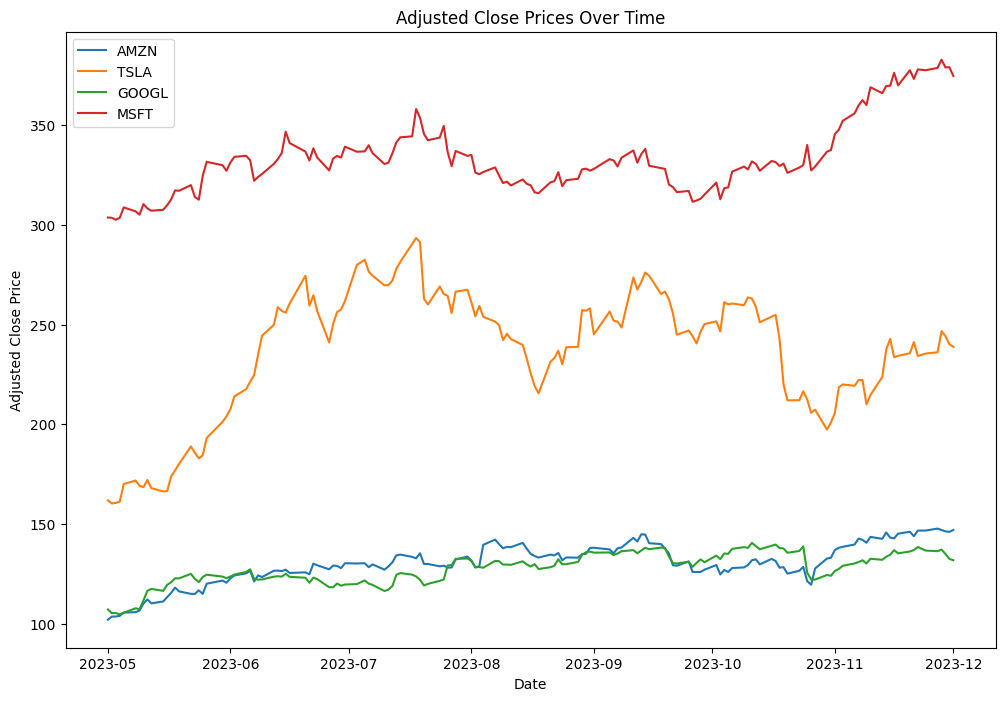

In [25]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(12, 8))

for ticker in tickers:
    plt.plot(data.index, data['Adj Close'][ticker], label=ticker)

plt.title('Adjusted Close Prices Over Time')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.show()

**RISK ANALYSIS ATTEMPT**

In [28]:
# Calculate volatility
daily_returns = data['Adj Close'].pct_change()
volatility = daily_returns.std()

# Calculate Sharpe ratio
sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(252)


confidence_level = 0.95
var = norm.ppf(1 - confidence_level, daily_returns.mean(), daily_returns.std())

cumulative_returns = (1 + daily_returns).cumprod()
peak = cumulative_returns.cummax()
drawdown = (cumulative_returns - peak) / peak
max_drawdown = drawdown.min()


Visualisation:

IndexError: index 1682899200000000000 is out of bounds for axis 0 with size 150

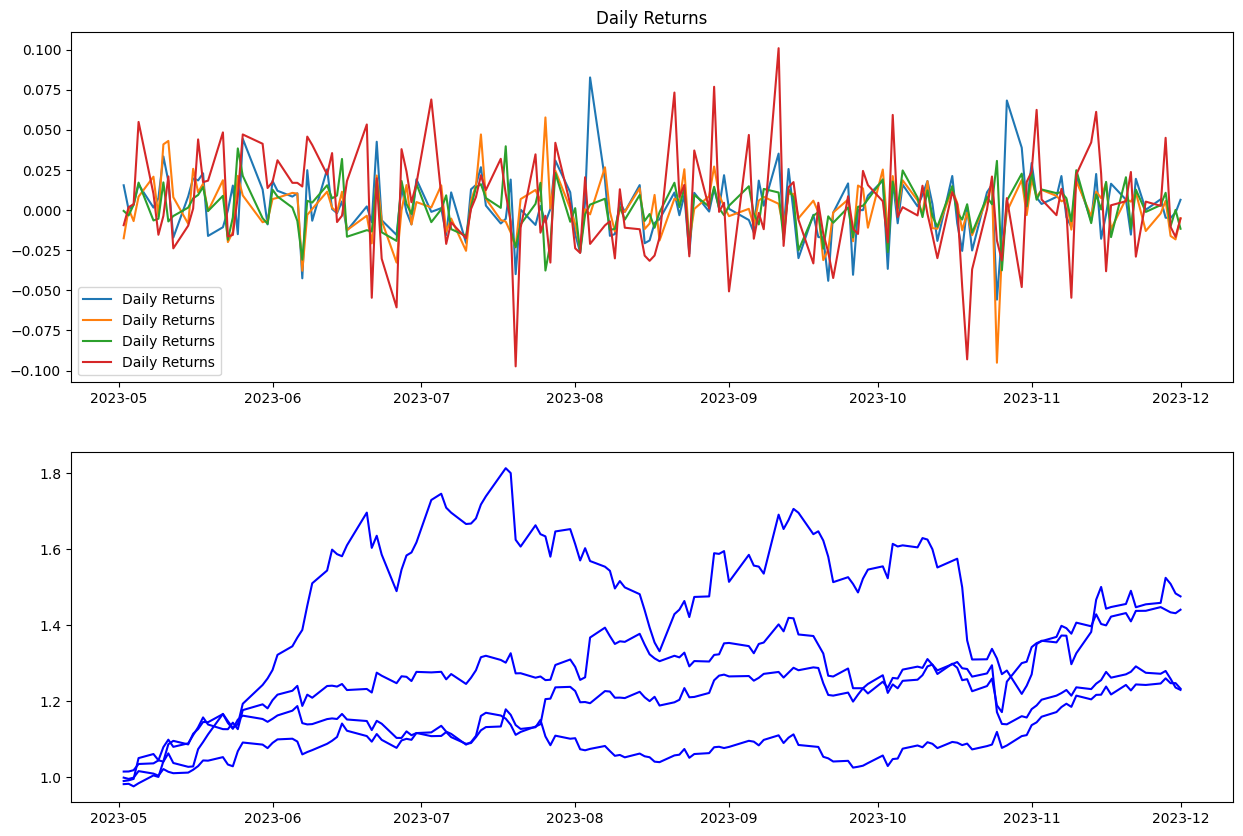

In [30]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming daily_returns, cumulative_returns, and max_drawdown are already defined

# Increase the figure size
plt.figure(figsize=(15, 10))

# Plotting daily returns
plt.subplot(2, 1, 1)
plt.plot(daily_returns, label='Daily Returns')
plt.title('Daily Returns')
plt.legend()

# Plotting cumulative returns and highlighting maximum drawdown
plt.subplot(2, 1, 2)
plt.plot(cumulative_returns, label='Cumulative Returns', color='blue')

# Create an array of zeros with the same length as cumulative_returns
zero_line = np.zeros_like(cumulative_returns)

# Highlighting maximum drawdown
drawdown_threshold = 0.05  # Set a threshold for drawdown visibility
highlight_drawdown = drawdown[drawdown < -drawdown_threshold]

# Convert indices to integer values
highlight_drawdown_indices = highlight_drawdown.index.astype(int)

plt.fill_between(
    x=highlight_drawdown_indices,
    y1=zero_line[highlight_drawdown_indices],
    y2=cumulative_returns[highlight_drawdown_indices],
    color='red', alpha=0.3, label='Drawdown'
)

# Increase the figure size
plt.figure(figsize=(28,10))

plt.title('Cumulative Returns with Maximum Drawdown')
plt.legend()
plt.tight_layout()
plt.show()


Portfolio Construction:


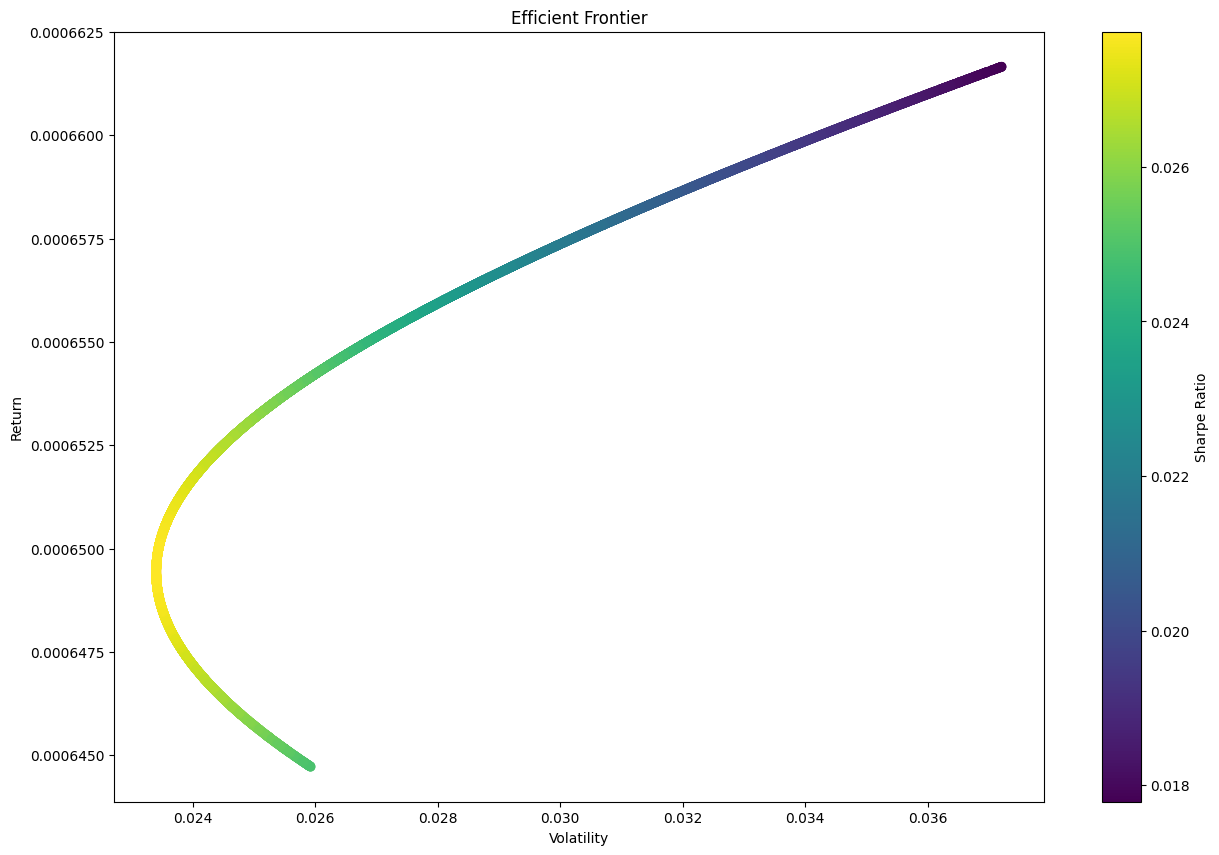

In [ ]:
# Calculate mean returns
mean_returns = daily_returns.mean()

# Calculate covariance matrix
cov_matrix = daily_returns.cov()

from scipy.optimize import minimize

def objective(weights):
    # Objective function to minimize - negative Sharpe ratio
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -portfolio_return / portfolio_volatility

# Constraints: weights sum to 1
constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})

# Bounds: weights between 0 and 1
bounds = tuple((0, 1) for asset in range(len(tickers)))

# Initial weights
initial_weights = [1. / len(tickers) for _ in range(len(tickers))]

# Optimize
result = minimize(objective, initial_weights, method='SLSQP', bounds=bounds, constraints=constraints)
optimal_weights = result.x

#---------------------------------------------------------------------------------------------------------------------------------------------------------------

# Simulate portfolios for the efficient frontier
port_returns = []
port_volatilities = []

for _ in range(10000):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)

    # Calculate portfolio return and volatility
    portfolio_return = np.dot(weights, mean_returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))

    # Append to lists
    port_returns.append(portfolio_return)
    port_volatilities.append(portfolio_volatility)

# Convert lists to NumPy arrays
port_returns = np.array(port_returns)
port_volatilities = np.array(port_volatilities)


# Increase the figure size
plt.figure(figsize=(15, 10))

# Plot the efficient frontier
plt.scatter(port_volatilities, port_returns, c=port_returns/port_volatilities, marker='o')
plt.title('Efficient Frontier')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.colorbar(label='Sharpe Ratio')
plt.show()


**Performance Metric**

In [31]:
# Calculate Total Return, Annualized Return, and Maximum Drawdown:

# Total Return
total_return = cumulative_returns.iloc[-1] - 1

# Annualized Return
annualized_return = (1 + total_return) ** (252 / len(cumulative_returns.index.year.unique())) - 1

# Maximum Drawdown
max_drawdown = drawdown.min()

print("Total Return:", total_return)
print("Annualized Return:", annualized_return)
print("Maximum Drawdown:", max_drawdown)


Total Return: AMZN     0.440764
GOOGL    0.230037
MSFT     0.233430
TSLA     0.475808
Name: 2023-12-01 00:00:00, dtype: float64
Annualized Return: AMZN     9.234614e+39
GOOGL    4.564694e+22
MSFT     9.137414e+22
TSLA     3.940220e+42
Name: 2023-12-01 00:00:00, dtype: float64
Maximum Drawdown: AMZN    -0.174525
GOOGL   -0.130772
MSFT    -0.129876
TSLA    -0.327197
dtype: float64


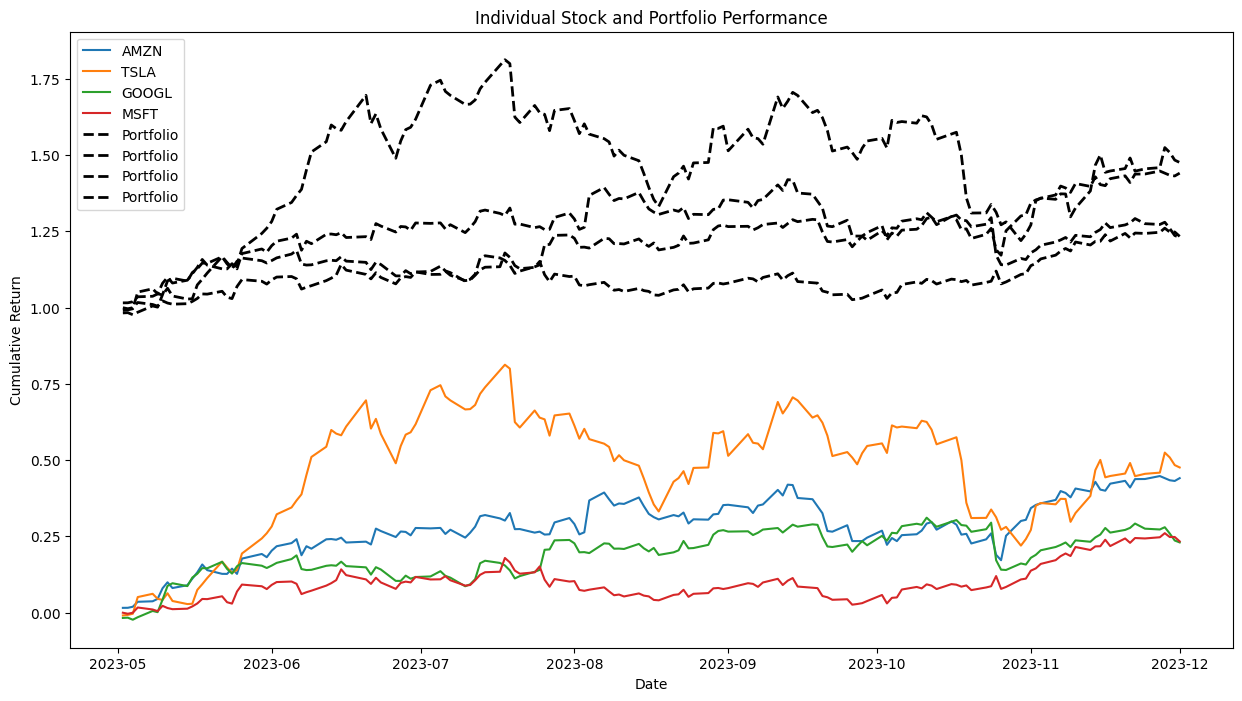

In [32]:
# Assuming individual stock prices are stored in a DataFrame named 'data'

# Calculate individual stock returns
individual_stock_returns = data['Adj Close'].pct_change()

# Calculate individual stock total returns
individual_stock_total_returns = (1 + individual_stock_returns).cumprod() - 1

# Compare individual stock and portfolio performance
plt.figure(figsize=(15, 8))

# Plot individual stock total returns
for stock in tickers:
    plt.plot(individual_stock_total_returns.index, individual_stock_total_returns[stock], label=stock)

# Plot portfolio cumulative returns
plt.plot(cumulative_returns.index, cumulative_returns, label='Portfolio', linestyle='--', linewidth=2, color='black')

plt.title('Individual Stock and Portfolio Performance')
plt.xlabel('Date')
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()



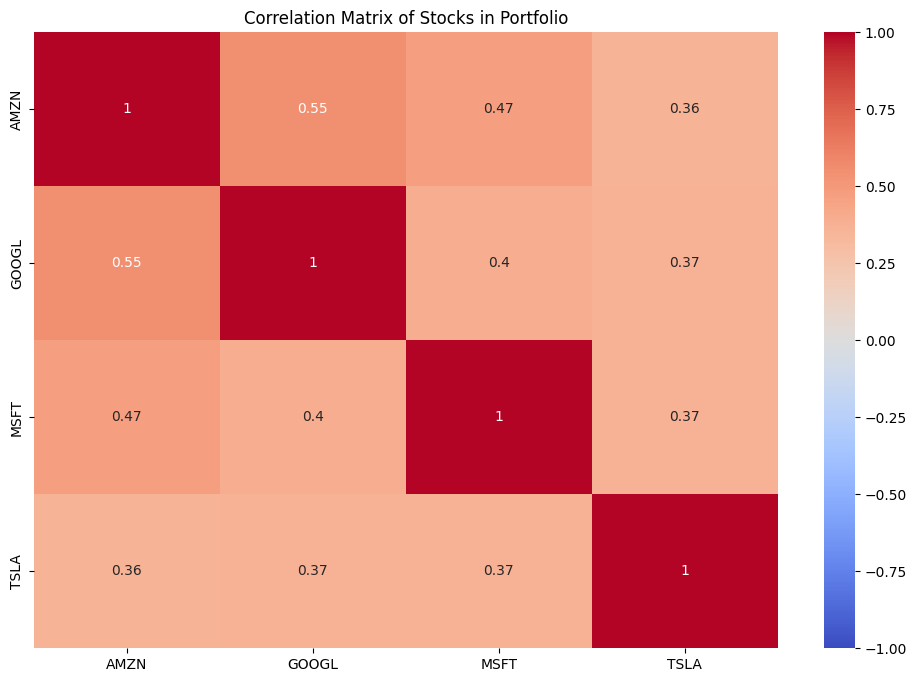

In [33]:
# Calculate correlation matrix
correlation_matrix = daily_returns.corr()

# Display heatmap of the correlation matrix
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Stocks in Portfolio')
plt.show()


In [35]:
# Calculate rolling correlation
rolling_correlation = daily_returns.rolling(window=30).corr()

# Select two stocks for illustration
stock1 = 'AMZN'
stock2 = 'GOOGL'

# Plot rolling correlation between two stocks
plt.figure(figsize=(15, 8))
plt.plot(rolling_correlation[stock1][stock2], label=f'{stock1} vs {stock2}')

plt.title(f'Rolling Correlation between {stock1} and {stock2}')
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend()
plt.show()


KeyError: 'GOOGL'

<Figure size 1500x800 with 0 Axes>

In [40]:


# Assuming 'data' is your DataFrame with historical stock prices

# Feature engineering
data['SMA_50'] = data['Adj Close'].rolling(window=50).mean()

# Drop rows with missing values
data = data.dropna()

# Define features and target
features = data[['Adj Close', 'SMA_50']]
target = data['Adj Close'].shift(-1)  # Shift target to represent next day's closing price

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Model selection and training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Model evaluation
predictions = model.predict(X_test)
mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error: {mse}')

# Predict next day's closing price
new_data = pd.DataFrame({'Adj Close': [latest_close_price], 'SMA_50': [latest_sma_50]})
next_day_prediction = model.predict(new_data)
print(f'Predicted Next Day\'s Closing Price: {next_day_prediction[0]}')


ValueError: Cannot set a DataFrame with multiple columns to the single column SMA_50